In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Import Data

In [2]:
df_reviews = pd.read_csv("reviews.csv", engine = "python", error_bad_lines=False)
df_listings = pd.read_csv("listings.csv", engine = "python", error_bad_lines=False)
df_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r<br/>Nous avons ...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...
...,...,...,...,...,...,...
848720,51909801,439754058671859318,2021-08-29,210113336,Ari,This was one of the Best hotel experiences I h...
848721,51910059,439796226033211137,2021-08-29,175633805,Leo,The room was exactly as described and was over...
848722,51921047,439769182951927960,2021-08-29,255614539,Niki,Fast response <br/>Easy check in <br/><br/>Dep...
848723,51926089,441249378414275416,2021-08-31,419619884,Ingrid,Amazing location and place! You will love it !


# Data Preprocessing & EDA

In [3]:
pd.set_option('display.max_column',None)

df_reviews = df_reviews.groupby('listing_id',as_index=False).agg({'comments': 'sum'}) # add all comment to a list groupby listing_id
# print(df_reviews.head)
df_reviews = df_reviews.rename(columns={"listing_id": "id"})

# get combine df
df = pd.merge(df_reviews, df_listings, on="id",how = 'inner')
df.info()

pd.set_option('display.max_column',None)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27627 entries, 0 to 27626
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            27627 non-null  int64  
 1   comments                                      27627 non-null  object 
 2   listing_url                                   27627 non-null  object 
 3   scrape_id                                     27627 non-null  int64  
 4   last_scraped                                  27627 non-null  object 
 5   name                                          27621 non-null  object 
 6   description                                   27026 non-null  object 
 7   neighborhood_overview                         18243 non-null  object 
 8   picture_url                                   27627 non-null  object 
 9   host_id                                       27627 non-null 

4


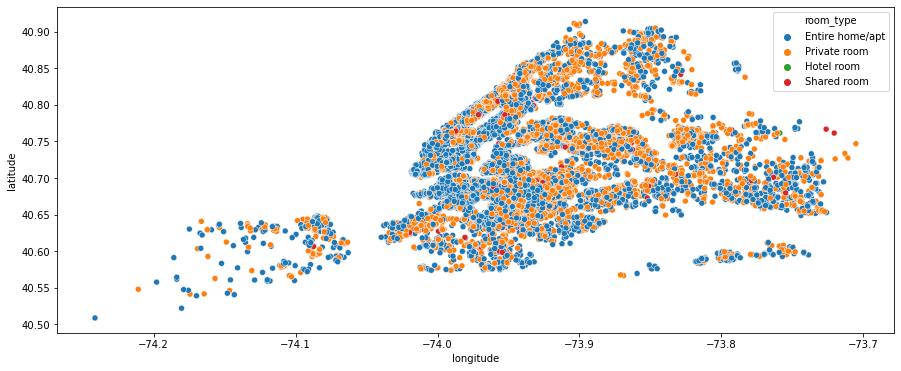

In [4]:
print(df.room_type.nunique())
plt.figure(figsize=(15, 6))
sns.scatterplot(x=df.longitude,y=df.latitude,hue=df.room_type);

In [5]:
# drop none value column
df.drop(['bathrooms','calendar_updated','license'],axis=1,inplace=True)
# drop useless url
df.drop(['host_thumbnail_url','host_picture_url','listing_url','picture_url'],axis=1,inplace=True)
comments = df['comments']
df.drop(['id','comments','name','description','neighborhood_overview','host_id',
         'host_url','host_name','host_about'],axis=1, inplace=True)
df.drop(['scrape_id','last_scraped','calendar_last_scraped'],axis=1,inplace=True)
df.drop(['host_location'],axis=1, inplace=True) #df['host_location'].nunique() = 1323
df.drop(['amenities'],axis=1, inplace=True)

# Replace'host_is_superhost' 'host_has_profile_pic' 'host_identity_verified' 'host_is_superhost''has_availability' t to 1, f or nan to 0
df['host_has_profile_pic']=np.where(df['host_has_profile_pic']=='t',1,0)
df['host_identity_verified']=np.where(df['host_identity_verified']=='t',1,0)
df['host_is_superhost']=np.where(df['host_is_superhost']=='t',1,0)
df['has_availability']=np.where(df['has_availability']=='t',1,0)
df['instant_bookable']=np.where(df['instant_bookable']=='t',1,0)

# Convert Strings to Datetime
df['host_since'] = pd.to_datetime(df['host_since'], format='%Y-%m-%d')
df['first_review'] = pd.to_datetime(df['first_review'], format='%Y-%m-%d')
df['last_review'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d')
df['host_since_days'] = df['host_since'].apply(lambda x: (datetime.datetime.now()-x).days)
df['first_review_days'] = df['first_review'].apply(lambda x: (datetime.datetime.now()-x).days)
df['last_review_days'] =df['last_review'].apply(lambda x: (datetime.datetime.now()-x).days)
df.drop(['host_since','first_review','last_review'],axis=1, inplace=True)


df['host_response_rate'] = df['host_response_rate'].str.replace('%','').astype(float)/100
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%','').astype(float)/100
df['price'] = df['price'].apply(lambda x: float(x.replace('$','').replace(',','')))

# fill numeric column with it's mean
object_list = []
for i in df:
    if df[i].dtype != object:
        df[i].fillna(df[i].median(), inplace=True)
    else:
        object_list.append(i)

#df.columns.to_list()

In [6]:
# get dummies
for i in object_list:
    if i != 'host_verifications':
        temp = pd.get_dummies(df[i],prefix=i,prefix_sep='_')
        df.drop([i],axis=1,inplace=True)
        df = pd.concat([df, temp],axis = 1)

#df.columns.to_list()

In [7]:
# data process for host_verifications column, convert to dummies
hv_values = set()
for i in df['host_verifications']:
    i = i.replace('[','')
    i = i.replace(']','')
    i = i.replace("\'",'')
    temp = i.split(', ')
    for ii in temp:
        hv_values.add(ii)
hv_values.remove('')
#hv_values

In [8]:
hv_df = pd.DataFrame(np.zeros((df.shape[0],len(hv_values))),
                     columns = list(hv_values))
for i in hv_values:
    for row in range(df['host_verifications'].shape[0]):
        if i in df['host_verifications'][row]:
            hv_df[i][row] = 1 # fill value by related row
hv_df.describe() # check distribution

,selfie,jumio,sesame_offline,kba,offline_government_id,phone,manual_offline,work_email,None,identity_manual,government_id,facebook,zhima_selfie,sent_id,reviews,sesame,email,weibo,google,manual_online
count,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000,27627.000000
mean,0.283418,0.398885,0.000615,0.229739,0.448728,0.995910,0.013682,0.144460,0.000688,0.255656,0.632099,0.184566,0.000398,0.001520,0.663988,0.000615,0.934050,0.000688,0.043291,0.006190
std,0.450666,0.489678,0.024799,0.420673,0.497373,0.063825,0.116170,0.351562,0.026216,0.436237,0.482243,0.387952,0.019950,0.038961,0.472352,0.024799,0.248199,0.026216,0.203515,0.078432
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df = pd.concat([df, hv_df],axis = 1)
df.drop(['host_verifications'],axis=1, inplace=True)

In [10]:
print('Shape of dataframe',df.shape,'\n')
print('Does dataframe have nan value:',df.isnull().values.any(),'\n')
df.info()

Shape of dataframe (27627, 989) 

Does dataframe have nan value: False 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27627 entries, 0 to 27626
Columns: 989 entries, host_response_rate to manual_online
dtypes: float64(44), int32(5), int64(16), uint8(924)
memory usage: 38.7 MB


In [11]:
non_dummies = ['host_response_rate',
               'host_acceptance_rate',
               'host_is_superhost',
               'host_listings_count',
               'host_total_listings_count',
               'host_has_profile_pic',
               'host_identity_verified',
               'latitude',
               'longitude',
               'accommodates',
               'bedrooms',
               'beds',
               'price',
               'minimum_nights',
               'maximum_nights',
               'minimum_minimum_nights',
               'maximum_minimum_nights',
               'minimum_maximum_nights',
               'maximum_maximum_nights',
               'minimum_nights_avg_ntm',
               'maximum_nights_avg_ntm',
               'has_availability',
               'availability_30',
               'availability_60',
               'availability_90',
               'availability_365',
               'number_of_reviews',
               'number_of_reviews_ltm',
               'number_of_reviews_l30d',
               'review_scores_rating',
               'review_scores_accuracy',
               'review_scores_cleanliness',
               'review_scores_checkin',
               'review_scores_communication',
               'review_scores_location',
               'review_scores_value',
               'instant_bookable',
               'calculated_host_listings_count',
               'calculated_host_listings_count_entire_homes',
               'calculated_host_listings_count_private_rooms',
               'calculated_host_listings_count_shared_rooms',
               'reviews_per_month',
               'host_since_days',
               'first_review_days',
               'last_review_days']
len(non_dummies)

45

In [12]:
df[non_dummies].corr()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_days,first_review_days,last_review_days
host_response_rate,1.000000,0.376488,0.124987,0.000702,0.000702,0.004909,0.035658,-0.033734,0.019695,-0.009803,-0.012788,0.004669,-0.014317,-0.035301,0.002064,-0.032495,-0.012527,-0.001180,-0.008519,-0.013346,-0.004512,-0.061095,-0.192758,-0.208511,-0.221021,-0.212163,0.024817,0.048406,0.066283,0.061132,0.098850,0.069933,0.088446,0.115513,0.054856,0.088054,0.067364,-0.065607,-0.109922,0.031559,-0.036479,0.038460,0.046994,0.034615,0.041879
host_acceptance_rate,0.376488,1.000000,0.061052,0.026089,0.026089,-0.008134,0.016594,0.007297,0.017814,0.019286,-0.019231,0.013001,0.000904,-0.042160,0.001913,-0.040336,-0.008971,0.014093,0.017398,-0.010184,0.016404,-0.035369,-0.025276,-0.045434,-0.061994,-0.106557,0.039799,0.130236,0.122233,-0.017219,0.002264,0.006372,-0.004915,0.005853,-0.002604,-0.001189,0.265166,-0.017259,0.000430,-0.031946,0.020481,0.099559,-0.130421,-0.067836,-0.011291
host_is_superhost,0.124987,0.061052,1.000000,-0.037614,-0.037614,0.014626,0.011009,-0.057182,0.062775,0.064679,0.047676,0.078243,0.006105,-0.120349,-0.003287,-0.117217,-0.093263,0.006081,-0.000340,-0.095758,0.002847,0.094613,0.014304,0.041770,0.072153,0.112106,0.280951,0.190562,0.152206,0.165855,0.137429,0.179262,0.120046,0.127274,0.073225,0.140445,-0.003972,-0.055764,-0.068862,-0.003011,-0.019081,0.138488,0.012923,-0.029287,-0.298747
host_listings_count,0.000702,0.026089,-0.037614,1.000000,1.000000,0.006642,0.037006,0.030521,-0.045635,-0.013879,-0.016764,-0.022822,0.045531,0.015906,-0.000644,0.063214,0.494972,-0.001326,-0.001543,0.490090,-0.001502,0.021756,-0.000567,0.022492,0.030787,0.078205,-0.044912,-0.015732,-0.017073,-0.021599,-0.033725,-0.008136,-0.020942,-0.062888,0.012677,-0.072090,0.076370,0.501585,0.547246,0.140668,-0.006801,-0.016354,-0.042397,-0.072306,-0.041773
host_total_listings_count,0.000702,0.026089,-0.037614,1.000000,1.000000,0.006642,0.037006,0.030521,-0.045635,-0.013879,-0.016764,-0.022822,0.045531,0.015906,-0.000644,0.063214,0.494972,-0.001326,-0.001543,0.490090,-0.001502,0.021756,-0.000567,0.022492,0.030787,0.078205,-0.044912,-0.015732,-0.017073,-0.021599,-0.033725,-0.008136,-0.020942,-0.062888,0.012677,-0.072090,0.076370,0.501585,0.547246,0.140668,-0.006801,-0.016354,-0.042397,-0.072306,-0.041773
host_has_profile_pic,0.004909,-0.008134,0.014626,0.006642,0.006642,1.000000,0.049175,-0.005717,-0.006571,-0.008195,-0.008453,-0.004511,-0.006250,-0.004032,0.000398,-0.003533,-0.000379,0.002142,0.002504,-0.000576,0.002407,0.000056,-0.029255,-0.028745,-0.026094,-0.022991,0.008620,0.010408,-0.005887,0.011212,0.019478,0.008455,0.019753,0.019448,-0.000753,0.002718,-0.005454,0.014579,0.010888,0.010040,0.002455,-0.003339,0.046778,0.021193,0.011944
host_identity_verified,0.035658,0.016594,0.011009,0.037006,0.037006,0.049175,1.000000,0.018364,-0.063162,0.011203,0.001476,-0.000471,0.011222,-0.007931,0.002639,-0.007967,0.010858,0.014981,0.017523,0.009279,0.016837,0.025416,-0.035358,-0.035560,-0.035736,-0.013264,0.008642,0.008893,0.011902,0.030863,-0.011662,-0.002031,-0.004011,-0.002816,0.009247,-0.014990,-0.011595,0.067802,0.034792,0.066919

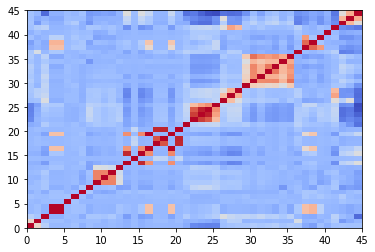

In [13]:
import matplotlib.pyplot as plot
plot.pcolor(df[non_dummies].corr(),cmap='coolwarm') #https://matplotlib.org/examples/color/colormaps_reference.html
plot.show()

# Export Dummy Dataframe and no dammy dataframe

In [14]:
df_nd = df[non_dummies]

In [15]:
df

host_response_rate  host_acceptance_rate  host_is_superhost  \
0                    0.34                  0.19                  0   
1                    0.50                  0.86                  0   
2                    1.00                  0.90                  0   
3                    0.50                  0.33                  0   
4                    1.00                  1.00                  0   
...                   ...                   ...                ...   
27622                0.88                  1.00                  0   
27623                0.88                  1.00                  0   
27624                0.88                  1.00                  0   
27625                0.88                  1.00                  1   
27626                1.00                  1.00                  0   

       host_listings_count  host_total_listings_count  host_has_profile_pic  \
0                      6.0                        6.0                     1   
1                      1.0                        1.0                     1   
2                      1.0                        1.0                     1   
3                      1.0                        1.0                     1   
4                      1.0                        1.0                     1   
...                    ...                        ...                   ...   
27622                  1.0                        1.0                     1   
27623                  1.0                        1.0                     1   
27624                  1.0                        1.0                     1   
27625                  2.0                        2.0                     1   
27626                  1.0                        1.0                     1   

       host_identity_verified   latitude  longitude  accommodates  bedrooms  \
0                           1  40.753560 -73.985590             1       1.0   
1                           1  40.684940 -73.957650             3       1.0   
2                           1  40.685350 -73.955120             2       1.0   
3                           1  40.662650 -73.994540             4       2.0   
4                           0  40.764570 -73.983170             2       1.0   
...                       ...        ...        ...           ...       ...   
27622                       1  40.749936 -73.982793             2       1.0   
27623                       1  40.751444 -73.984188             2       1.0   
27624                       1  40.750898 -73.984803             2       1.0   
27625                       0  40.584041 -74.107198             4       1.0   
27626                       1  40.695272 -73.909378             1       1.0   

       beds  price  minimum_nights  maximum_nights  minimum_minimum_nights  \
0       1.0  150.0              30            1125                    30.0   
1       3.0   76.0               1             730                     1.0   
2       1.0   60.0              30             730                    30.0   
3       2.0  275.0               5            1125                     5.0   
4       1.0   68.0               2              14                     2.0   
...     ...    ...             ...             ...                     ...   
27622   1.0  129.0               1              28                     1.0   
27623   1.0  135.0               1              28                     1.0   
27624   1.0  235.0               1              28                     1.0   
27625   2.0  135.0               1             365                     1.0   
27626   1.0   50.0               1             365                     1.0   

       maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
0                        30.0                  1125.0                  1125.0   
1                         1.0                  1125.0                  1125.0   
2                        30.0                   730.0                   730.0   
3      

In [16]:
df.to_csv('dummy_df.csv',index = False)
df_nd.to_csv('no_dummy_df.scv',index = False)